## Load Dataset

In [4]:
# all packages for training the model
import torch
import torchvision
from torchvision import transforms
from torchvision.utils import make_grid
from torchvision.datasets import ImageFolder
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split

import torch.nn as nn
import torch.nn.functional as F

import numpy as np
import cv2
import imutils
import matplotlib.pyplot as plt
import time
from natsort import natsorted
from sklearn.metrics import confusion_matrix
import seaborn as sns


In [4]:
# train and test data directory
data_dir = "../../02_data_crop_abc/train"
test_data_dir = "../../02_data_crop_abc/test"


# load the train and test data as Tensors + resize the images
dataset = ImageFolder(data_dir,transform = transforms.Compose([transforms.Resize((64,64)),transforms.ToTensor()]))
test_dataset = ImageFolder(test_data_dir,transforms.Compose([transforms.Resize((64,64)),transforms.ToTensor()]))

checks shape

In [5]:
img, label = dataset[0]
print('Image Shape: ', img.shape,label)  # Channel, height, width

Image Shape:  torch.Size([3, 64, 64]) 0


checks number of labels

In [6]:
# automatic assignment of images and labels
# 26 classes: for each letter one class
print("Follwing classes are there : \n",natsorted(dataset.classes))

Follwing classes are there : 
 ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']


checks whether images and labels have been assigned correctly

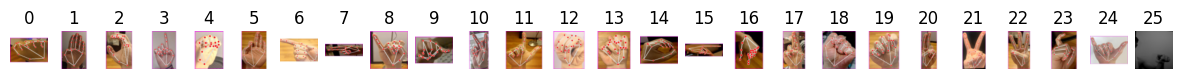

correct assignment


In [7]:
# DataLoader convert labels into numbers
data_loader = torch.utils.data.DataLoader(dataset, batch_size=1, shuffle=False)

# empty dictionary to store one image per class
class_images = {}

for images, labels in data_loader:
    image = images[0]  
    label = labels[0].item() 


    # checks whether label already exists in class_images, if not, it is added along with the image
    if label not in class_images:
        class_images[label] = image

    # when all labels are present, the loop ends
    if len(class_images) == len(dataset.classes):
        break

fig, axs = plt.subplots(1, len(class_images), figsize=(15, 5))
for i, (label, image) in enumerate(class_images.items()):
    axs[i].imshow(image.permute(1, 2, 0))
    axs[i].set_title(label)
    axs[i].axis('off')

plt.show()
print('correct assignment')

Label : a


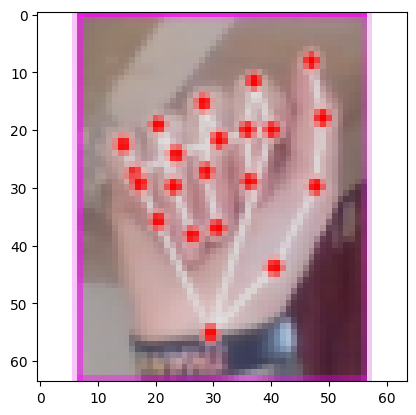

In [8]:
# Dataset is not shuffeld
def display_img(img,label):
    print(f"Label : {dataset.classes[label]}")
    plt.imshow(img.permute(1,2,0))

#display image in the dataset
display_img(*dataset[100])

Division into validation and test data

In [9]:
batch_size = 128
val_size = 2000
train_size = len(dataset) - val_size 

train_data,val_data = random_split(dataset,[train_size,val_size])
print(f"Length of Train Data : {len(train_data)}")
print(f"Length of Validation Data : {len(val_data)}")
print(f"Length of Test Data : {len(test_dataset)}")
print(f"Label : {len(train_data.dataset.classes)}" + '\n')
print("Classes in train data: \n", train_data.dataset.classes)
print("Classes in val data: \n", val_data.dataset.classes)

#load the train and validation into batches and shuffle train_dl
train_dl = DataLoader(train_data, batch_size, shuffle = True, num_workers = 4, pin_memory = True)
val_dl = DataLoader(val_data, batch_size*2, num_workers = 4, pin_memory = True)
test_dl = DataLoader(test_dataset, batch_size*2, num_workers = 4, pin_memory = True)

Length of Train Data : 16178
Length of Validation Data : 2000
Length of Test Data : 3640
Label : 26

Classes in train data: 
 ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
Classes in val data: 
 ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']


When loading with the DataLoader, the labels are converted into numbers
Therefore the assignment is checked again

In [10]:
label_to_letter = {0: 'a', 1: 'b', 2: 'c', 3: 'd', 4: 'e', 5: 'f', 6:'g', 7:'h', 8:'i', 9:'j', 10:'k', 11:'l', 12:'m', 13:'n', 14:'o', 15:'p', 16:'q', 17:'r', 18:'s', 
                   19:'t', 20:'u', 21:'v', 22:'w', 23:'x', 24:'y', 25: 'z'}

# only show the first batch
batch_count = 0
for images, labels in train_dl:
    if batch_count < 1:
        letter_labels = [label_to_letter[label.item()] for label in labels]   # translation with the dictionary
        batch_count += 1
    else:
        break

    print("Numerische Labels für diesen Batch: ", labels)
    print("Buchstaben-Labels für diesen Batch: ", letter_labels)

Numerische Labels für diesen Batch:  tensor([ 6, 25,  8,  4, 14, 19,  3, 18,  7, 14, 22, 23, 25, 22, 16,  4,  1, 20,
        11, 11, 19, 23, 20,  1,  7,  0,  7,  3, 21, 21, 24, 17,  9,  6,  6, 11,
         5,  6,  1, 18,  2, 21, 10, 23, 15,  9, 19,  3, 21, 17, 24, 11,  1,  2,
        22,  6,  5,  2, 17, 18,  5, 23,  7, 23,  4,  0, 12, 20,  1, 18, 12, 21,
         3,  7,  7, 25,  2, 22, 10, 12,  0,  5, 15,  9, 18, 15, 17,  4,  2, 19,
         0, 15,  9,  2,  4,  9,  0, 23, 22, 23,  6, 19,  0, 19, 16,  9,  6, 19,
         4,  8, 21, 23,  3, 21, 22, 19, 13, 10, 24, 16, 13,  4,  4, 12,  5,  2,
         5, 20])
Buchstaben-Labels für diesen Batch:  ['g', 'z', 'i', 'e', 'o', 't', 'd', 's', 'h', 'o', 'w', 'x', 'z', 'w', 'q', 'e', 'b', 'u', 'l', 'l', 't', 'x', 'u', 'b', 'h', 'a', 'h', 'd', 'v', 'v', 'y', 'r', 'j', 'g', 'g', 'l', 'f', 'g', 'b', 's', 'c', 'v', 'k', 'x', 'p', 'j', 't', 'd', 'v', 'r', 'y', 'l', 'b', 'c', 'w', 'g', 'f', 'c', 'r', 's', 'f', 'x', 'h', 'x', 'e', 'a', 'm', 'u', 'b', 's'

Assignment: number - image


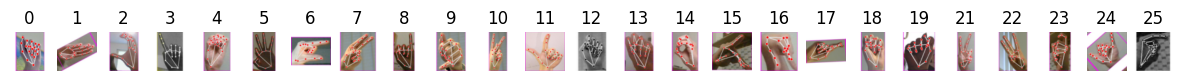

In [11]:
# empty dictionary to store one image per class
class_images = {}

for images, labels in train_dl:
    image = images[0]  
    label = labels[0].item() 


    # checks whether label already exists in class_images, if not, it is added along with the image
    if label not in class_images:
        class_images[label] = image

    # when all labels are present, the loop ends
    if len(class_images) == len(dataset.classes):
        break

sorted_labels = natsorted(class_images.keys())

print("Assignment: number - image")
fig, axs = plt.subplots(1, len(class_images), figsize=(15, 5))
for i, label in enumerate(sorted_labels):
    image = class_images[label]
    axs[i].imshow(image.permute(1, 2, 0))
    axs[i].set_title(label)
    axs[i].axis('off')

plt.show()

Assignment: number - letter


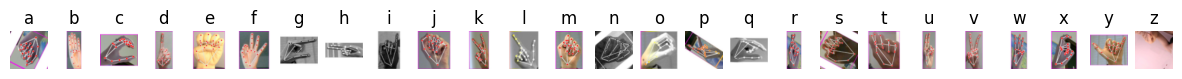

In [12]:
# empty dictionary to store one image per class
class_images = {}

for images, labels in train_dl:
    image = images[0]  
    label = labels[0].item() 

    letter_label = label_to_letter[label]

    # checks whether label already exists in class_images, if not, it is added along with the image
    if letter_label not in class_images:
        class_images[letter_label] = image

    # when all labels are present, the loop ends
    if len(class_images) == len(dataset.classes):
        break

sorted_labels = natsorted(class_images.keys())

print("Assignment: number - letter")
fig, axs = plt.subplots(1, len(class_images), figsize=(15, 5))
for i, label in enumerate(sorted_labels):
    image = class_images[label]
    axs[i].imshow(image.permute(1, 2, 0))
    axs[i].set_title(label)
    axs[i].axis('off')

plt.show()

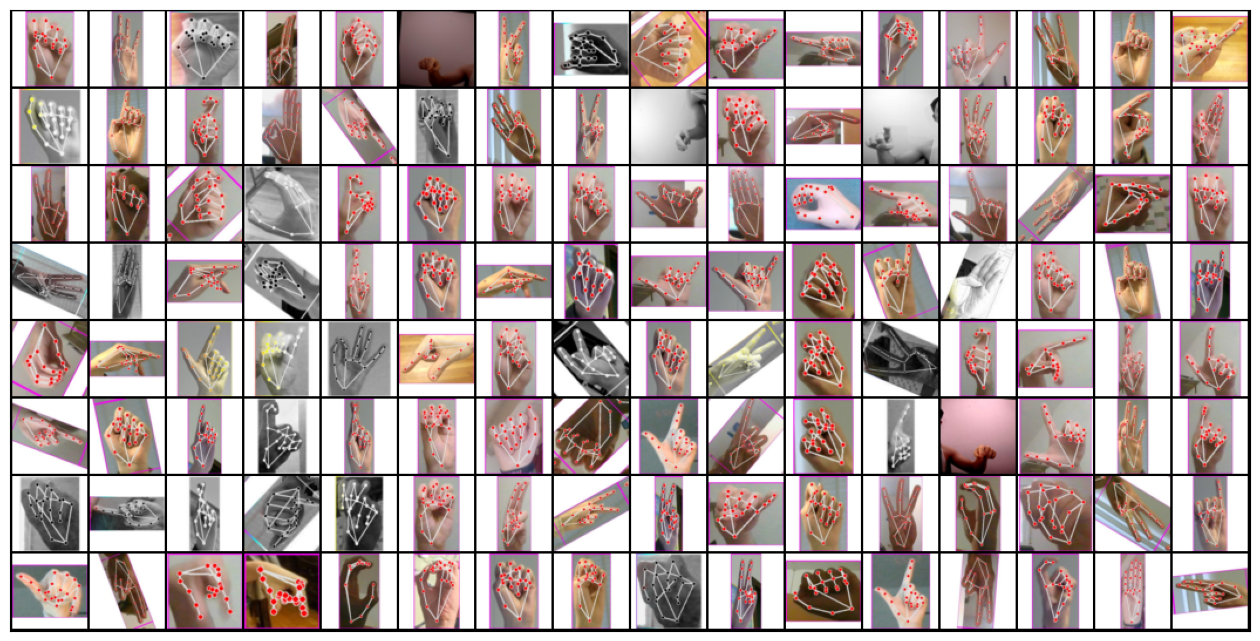

In [13]:
def show_batch(dl):
    """Plot images grid of single batch"""
    for images, labels in dl:
        fig,ax = plt.subplots(figsize = (16,12))
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(make_grid(images,nrow=16).permute(1,2,0))
        break
        
show_batch(train_dl)
# no order is recognizable

## Create Model

Define loss and accuracy + output

In [5]:
class ImageClassificationBase(nn.Module):  # parent class
    
    def training_step(self, batch):
        """ 
            calculates trainigs loss and accuracy
        """ 
        images, labels = batch # extracts images and labels from batch
        out = self(images)     # model is applied to the images
        train_loss = F.cross_entropy(out, labels) # calculates cross_entropy loss between predictions and labels
        train_acc = accuracy(out, labels) # calculates accuracy between predictions and labels
        return train_loss, train_acc
    
    def validation_step(self, batch):
        """ 
            calculates validation loss and accuray
            equivalent to training_step
        """ 
        images, labels = batch 
        out = self(images)                    
        loss = F.cross_entropy(out, labels)   
        acc = accuracy(out, labels)
        return {'val_loss': loss.detach(), 'val_acc': acc}  # loss will not calculated further as it is only for evualuation
        
    def validation_epoch_end(self, outputs):
        """ 
            combines loss and accuracy per batch for one epoch
        """
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        """ 
            defines output per epoch
        """
        print("Epoch [{}], train_loss: {:.4f}, train_acc: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['train_acc'], result['val_loss'], result['val_acc']))

Define model parameters

In [6]:
class NaturalSceneClassification(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            # Layer 1: Convolutional Layer with 3 input channels and 32 output channels
            nn.Conv2d(3, 32, kernel_size = 3, padding = 1),
            nn.ReLU(),

            # Layer 2: Convolutional Layer with 32 input channels and 64 output channels
            nn.Conv2d(32,64, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
        
            # Layer 4: Convolutional Layer with 64 input channels and 128 output channels
            nn.Conv2d(64, 128, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),

            # Layer 5: Convolutional Layer with 128 input channels and 128 output channels
            nn.Conv2d(128 ,128, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            
            # Layer 7: Convolutional Layer with 128 input channels and 256 output channels
            nn.Conv2d(128, 256, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),

            # Layer 8: Convolutional Layer with 256 input channels and 256 output channels
            nn.Conv2d(256,256, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            
            # Layer 10: Flatten Layer to transform data into vector
            nn.Flatten(),

            # Layer 11: Fully Connected Layer with input size (16384) and output size (1024)
            nn.Linear(16384,1024),  # last value = first value of the next layer
            nn.ReLU(),

            # Layer 12: Fully Connected Layer with input size (1024) and output size (512)
            nn.Linear(1024, 512),   # last value = first value of the next layer
            nn.ReLU(),

            # Layer 13: Fully Connected Layer with input size (512) and output size (26)
            nn.Linear(512,26)  # number of classes
        )
    
    def forward(self, xb):
        return self.network(xb)

In [7]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)  # get predicted labels
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))  # acc = correct preds/ number of preds

@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()  # set model on evaluation mode
    outputs = [model.validation_step(batch) for batch in val_loader]  # get values for each batch
    return model.validation_epoch_end(outputs)  # combines loss and accuracy per batch for one epoch

# training function  
def fit(epochs, lr, model, train_loader, val_loader, opt_func = torch.optim.SGD):
    
    history = []
    optimizer = opt_func(model.parameters(),lr)
    for epoch in range(epochs):
        
        model.train()
        train_losses = []
        train_accs = []
        for batch in train_loader:
            loss, _ = model.training_step(batch)
            _, acc = model.training_step(batch)
            train_losses.append(loss)
            train_accs.append(acc)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['train_acc'] = torch.stack(train_accs).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    
    return history

In [17]:
num_epochs = 10
opt_func = torch.optim.Adam
lr = 0.001
model = NaturalSceneClassification()

print("[INFO] training the network...")
startTime = time.time()

history = fit(num_epochs, lr, model, train_dl, val_dl, opt_func)

endTime = time.time()
print("[INFO] total time taken to train the model: {:.2f}min".format((endTime - startTime)/ 60))

[INFO] training the network...
Epoch [0], train_loss: 2.7279, train_acc: 0.1413, val_loss: 2.2277, val_acc: 0.3045
Epoch [1], train_loss: 1.5219, train_acc: 0.5194, val_loss: 1.0763, val_acc: 0.6765
Epoch [2], train_loss: 0.7179, train_acc: 0.7794, val_loss: 0.6209, val_acc: 0.8111
Epoch [3], train_loss: 0.4623, train_acc: 0.8543, val_loss: 0.5416, val_acc: 0.8357
Epoch [4], train_loss: 0.3261, train_acc: 0.8952, val_loss: 0.4938, val_acc: 0.8495
Epoch [5], train_loss: 0.2116, train_acc: 0.9314, val_loss: 0.4627, val_acc: 0.8797
Epoch [6], train_loss: 0.1765, train_acc: 0.9433, val_loss: 0.4462, val_acc: 0.8802
Epoch [7], train_loss: 0.1220, train_acc: 0.9618, val_loss: 0.4806, val_acc: 0.8780
Epoch [8], train_loss: 0.0974, train_acc: 0.9698, val_loss: 0.4777, val_acc: 0.9053
Epoch [9], train_loss: 0.0824, train_acc: 0.9737, val_loss: 0.4969, val_acc: 0.8959
Epoch [10], train_loss: 0.0700, train_acc: 0.9787, val_loss: 0.4734, val_acc: 0.9037
Epoch [11], train_loss: 0.0470, train_acc: 0

In [18]:
torch.save(model, ('output/model_epoch30.pth'))

## Evaluate Model

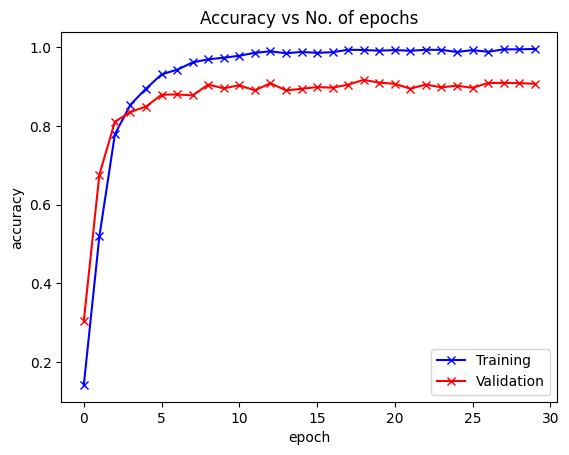

In [19]:
def plot_accuracies(history):
    """ Plot the history of accuracies"""
    val_acc = [x['val_acc'] for x in history]
    train_acc = [x['train_acc'] for x in history]
    plt.plot(train_acc, '-bx')
    plt.plot(val_acc, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.legend(['Training', 'Validation'])
    plt.title('Accuracy vs No. of epochs');
    

plot_accuracies(history)

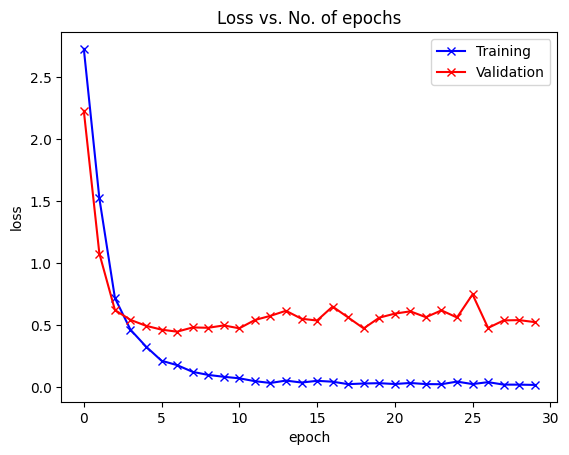

In [20]:
def plot_losses(history):
    """ Plot the losses in each epoch"""
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

plot_losses(history)

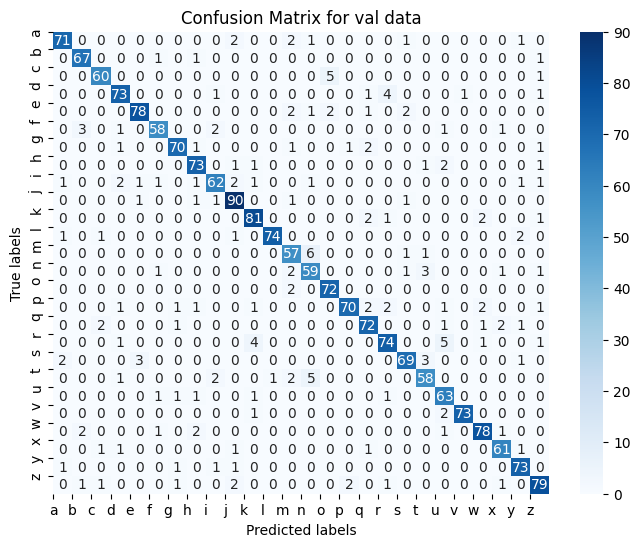

In [21]:
def get_all_predictions(model, data_loader):
    all_preds = []
    all_labels = []
    for batch in data_loader:
        images, labels = batch
        preds = model(images)
        _, pred_labels = torch.max(preds, dim=1)
        all_preds.extend(pred_labels.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
    return all_preds, all_labels

def plot_confusion_matrix(model, data_loader):
    """ 
        Comparison of actual labels and predicted labels
    """
    all_preds, all_labels = get_all_predictions(model, data_loader)
    all_labels_letters = [label_to_letter[label] for label in all_labels]
    all_preds_letters = [label_to_letter[label] for label in all_preds]

    cm = confusion_matrix(all_labels_letters, all_preds_letters)

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xticks(ticks=range(len(label_to_letter)), labels=label_to_letter.values())
    plt.yticks(ticks=range(len(label_to_letter)), labels=label_to_letter.values())
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title('Confusion Matrix for val data')
    plt.show()
plot_confusion_matrix(model, val_dl)

## Testing

In [1]:
# all packages for testing the model
import torch
import torchvision
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import Subset

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [8]:
# load saved model and put it in evaluation mode
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = torch.load("output/model_epoch30.pth").to(device)
model.eval()

NaturalSceneClassification(
  (network): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): Flatten(start_dim=1, end_dim=-1)
    (16): Linear(in_features=16384, out_features=1024, bias=True)
    (17): ReLU()
    (18): Li

In [9]:
batch_size = 128
test_data_dir = "../../02_data_crop_abc/test"
test_dataset = ImageFolder(test_data_dir,transforms.Compose([transforms.Resize((64,64)),transforms.ToTensor()]))
test_dl = DataLoader(test_dataset, batch_size*2, num_workers = 4, pin_memory = True)

In [10]:
label_to_letter = {0: 'a', 1: 'b', 2: 'c', 3: 'd', 4: 'e', 5: 'f', 6:'g', 7:'h', 8:'i', 9:'j', 10:'k', 11:'l', 12:'m', 13:'n', 14:'o', 15:'p', 16:'q', 17:'r', 18:'s', 
                   19:'t', 20:'u', 21:'v', 22:'w', 23:'x', 24:'y', 25: 'z'}

In [11]:
def get_acc_loss_for_testdata(model, test_loader):
    correct = 0
    total = 0
    test_loss = 0.0

    with torch.no_grad():  # no gradients are calculated
        
        for images, labels in test_loader:
            outputs = model(images) # put image into model

            # calculate loss
            loss = F.cross_entropy(outputs, labels)
            test_loss += loss.item()

            # calculate accuracy
            _, predicted = torch.max(outputs.data, 1)  # get predicted label
            total += labels.size(0)
            correct += torch.tensor(torch.sum(predicted == labels).item())

    test_acc =  correct / total
    test_loss = test_loss / len(test_dl)

    print('Accuracy on test data: {} %'.format(100 * test_acc))
    print('Average loss on test data: {}'.format(test_loss))

get_acc_loss_for_testdata(model, test_dl)
# test_dl is defined at the section: Load Data

Accuracy on test data: 68.62637329101562 %
Average loss on test data: 2.7634345988432565


In [28]:
print("[INFO] evaluating network...")

def get_classification_report(model, test_loader):
	preds = []
	targets = []

	for image, label in test_loader:
			pred = model(image)
			preds.extend(pred.argmax(axis=1).cpu().numpy())
			targets.extend(label.cpu().numpy())

	# generate a classification report
	print(classification_report(targets, np.array(preds), target_names=test_dataset.classes))

get_classification_report(model, test_dl)

[INFO] evaluating network...
              precision    recall  f1-score   support

           a       0.67      0.85      0.75       140
           b       0.41      0.95      0.58       140
           c       0.90      0.80      0.85       140
           d       0.23      0.34      0.28       140
           e       0.59      0.68      0.63       140
           f       0.97      0.55      0.70       140
           g       0.71      0.61      0.66       140
           h       0.81      0.47      0.60       140
           i       0.31      0.67      0.42       140
           j       0.37      0.22      0.28       140
           k       0.17      0.19      0.18       140
           l       0.95      0.71      0.82       140
           m       0.57      0.49      0.52       140
           n       0.69      0.64      0.66       140
           o       0.81      0.62      0.70       140
           p       0.67      0.72      0.70       140
           q       0.37      0.35      0.36       14

In [29]:
# get all predicted labels for test_data
def get_all_predictions(model, test_loader):
    all_preds = []
    all_labels = []
    for batch in test_loader:
        images, labels = batch
        preds = model(images)
        _, pred_labels = torch.max(preds, dim=1)

        all_preds.extend(pred_labels.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

    return all_preds, all_labels

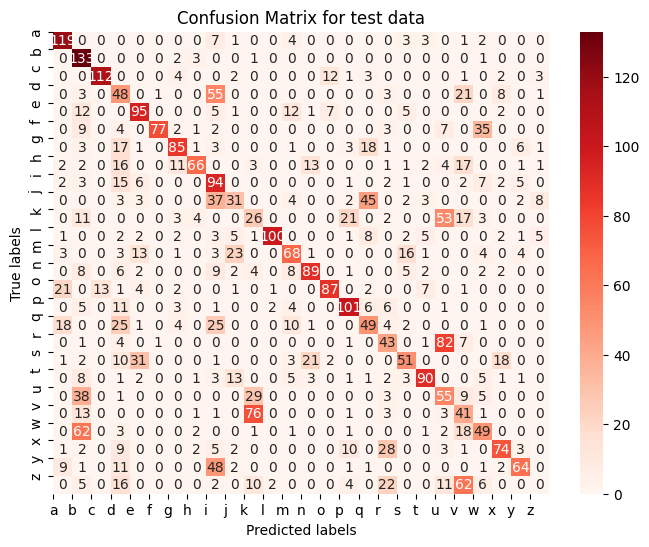

In [30]:
def plot_confusion_matrix(model, data_loader):
    all_preds, all_labels = get_all_predictions(model, data_loader)

    all_labels_letters = [label_to_letter[label] for label in all_labels]
    all_preds_letters = [label_to_letter[label] for label in all_preds]

    cm = confusion_matrix(all_labels_letters, all_preds_letters)

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Reds')
    plt.xticks(ticks=range(len(label_to_letter)), labels=label_to_letter.values())
    plt.yticks(ticks=range(len(label_to_letter)), labels=label_to_letter.values())
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title('Confusion Matrix for test data')
    plt.show()

# Verwende die Funktion plot_confusion_matrix nach dem Training deines Modells mit den Testdaten
plot_confusion_matrix(model, test_dl)

Predict single images from testdata

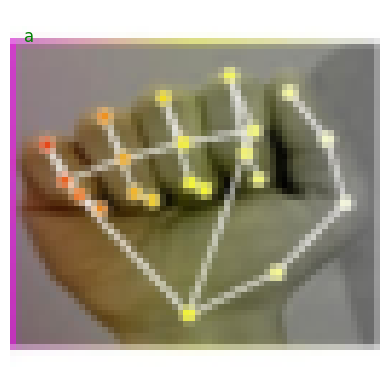

[INFO] ground truth label: a, predicted label: 0


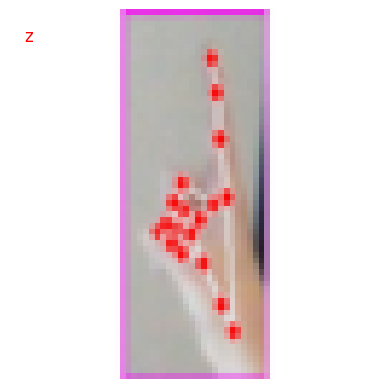

[INFO] ground truth label: z, predicted label: 21


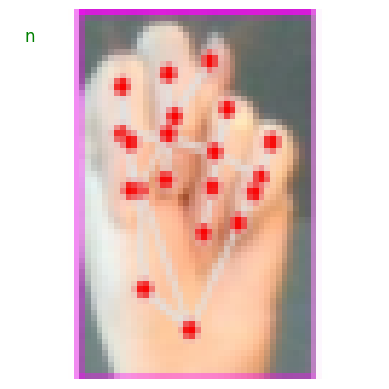

[INFO] ground truth label: n, predicted label: 13


In [31]:
def predict_single_image_from_test_data (model, test_dataset):
    # get three randomly selected images from test_dataset
    idxs = np.random.choice(range(0, len(test_dataset)), size=(3,))
    testData = Subset(test_dataset, idxs)
    testDataLoader = DataLoader(testData, batch_size=1)

    preds, orig_labels = get_all_predictions(model, testDataLoader)

    for idx, (image, label) in enumerate(testData):
        # transform image to plot it
        origImage = image.numpy()
        origImage = np.transpose(origImage, (1, 2, 0))

        pred = preds[idx]
        orig_label = orig_labels[idx]
        letter_label = label_to_letter[orig_label]  # change predicted number to predicted letter

        color = 'green' if orig_label == pred else 'red'  # visualize correct and false predictions
        plt.imshow(origImage)
        plt.text(2, 5, str(letter_label), fontsize=12, color=color)
        plt.axis('off')
        plt.show()

        # Anzeige der Ergebnisse im Terminal
        print("[INFO] ground truth label: {}, predicted label: {}".format(letter_label, pred))

predict_single_image_from_test_data(model, test_dataset)
# test_dataset is defined in the first code block

## Predict

predict single images with unknown class

Das Bild 00001.jpg wurde der Klasse b zugeordnet.


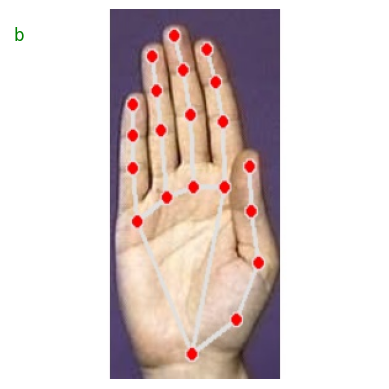

Das Bild 00002.jpg wurde der Klasse l zugeordnet.


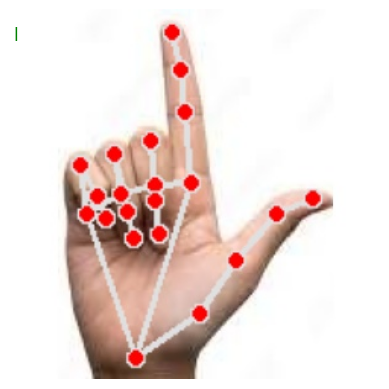

Das Bild B_00008.jpg wurde der Klasse l zugeordnet.


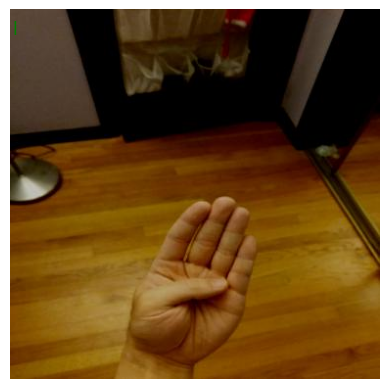

In [33]:
from PIL import Image
import os

def predict(model, data_dir):
    # same transformation as for input data
    transform = transforms.Compose([transforms.Resize((64,64)),transforms.ToTensor()])


    # run through all images in the folder
    for image_name in os.listdir(data_dir):
        image_path = os.path.join(data_dir, image_name)
        image = Image.open(image_path)
        image_tensor = transform(image).unsqueeze(0)

        output = model(image_tensor)  # put images into model

        predicted_class = torch.argmax(output).item()  # get predicted label
        letter_label = label_to_letter[predicted_class]  # change predicted number to predicted letter

        print(f'Das Bild {image_name} wurde der Klasse {letter_label} zugeordnet.')

        plt.imshow(image)
        plt.text(2, 25, str(letter_label), fontsize=12, color='green')
        plt.axis('off')
        plt.show()

data_dir = "../test_images"

predict(model, data_dir)